In [6]:
from tensorflow.keras.utils import normalize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import MeanIoU
import os
from glob import glob
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

### Architektura modelu

In [10]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=544, IMG_WIDTH=544, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [11]:
SIZE_X = 544
SIZE_Y = 544
n_classes = 4

### Načtení a předzpracování obrázků

In [12]:
input_dir = "./Ateroskleroza_Data_Original_26_9_19/images/"
mask_dir = "./Ateroskleroza_Data_Original_26_9_19/labels/"

train_images = []
for directory_path in glob(input_dir):
    for img_path in glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)
        train_images.append(img)
        
train_images = np.array(train_images)

train_masks = []
for directory_path in glob(mask_dir):
    for mask_path in glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)
        train_masks.append(mask)

train_masks = np.array(train_masks)

In [13]:
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1, 1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_reshaped_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_reshaped_encoded_original_shape)

C:\Users\107320\.conda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3], dtype=int64)

In [14]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks, axis=3)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state=42)

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

print("Class values in the dataset are ...", np.unique(y_train))

Class values in the dataset are ... [0 1 2 3]


In [16]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_masks_reshaped_encoded),
                                        y = train_masks_reshaped_encoded                                                    
                                    )

print("Class weights are ...:", class_weights)

Class weights are ...: [ 0.3444192   2.87042313 14.82685638  1.46899924]


In [17]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [18]:
model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 544, 544, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 544, 544, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 544, 544, 16  0           ['conv2d[0][0]']                 
                                )                                                             

 spose)                         )                                                                 
                                                                                                  
 concatenate_2 (Concatenate)    (None, 272, 272, 64  0           ['conv2d_transpose_2[0][0]',     
                                )                                 'conv2d_3[0][0]']               
                                                                                                  
 conv2d_14 (Conv2D)             (None, 272, 272, 32  18464       ['concatenate_2[0][0]']          
                                )                                                                 
                                                                                                  
 dropout_7 (Dropout)            (None, 272, 272, 32  0           ['conv2d_14[0][0]']              
                                )                                                                 
          

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
checkpointer = ModelCheckpoint('atherosclerosis_segmentation.h5', verbose=1, save_best_only=True)
callbacks = [
    EarlyStopping(patience=2, monitor='val_loss'),
    TensorBoard(log_dir='logs')
]

In [21]:
history = model.fit(X_train, y_train_cat,
                   batch_size = 16,
                   verbose=1,
                   epochs=50,
                   callbacks=callbacks,
                   validation_data=(X_test, y_test_cat),
                   shuffle=False)

Epoch 1/50
49/49 [==============================] - 1608s 33s/step - loss: 0.7032 - accuracy: 0.8179 - val_loss: 0.3325 - val_accuracy: 0.8627
Epoch 2/50
49/49 [==============================] - 1800s 37s/step - loss: 0.2663 - accuracy: 0.9055 - val_loss: 0.2374 - val_accuracy: 0.9261
Epoch 3/50
49/49 [==============================] - 1750s 36s/step - loss: 0.1734 - accuracy: 0.9408 - val_loss: 0.1593 - val_accuracy: 0.9411
Epoch 4/50
49/49 [==============================] - 1535s 31s/step - loss: 0.1407 - accuracy: 0.9470 - val_loss: 0.1265 - val_accuracy: 0.9520
Epoch 5/50
49/49 [==============================] - 1594s 33s/step - loss: 0.1182 - accuracy: 0.9579 - val_loss: 0.1102 - val_accuracy: 0.9611
Epoch 6/50
49/49 [==============================] - 1571s 32s/step - loss: 0.1022 - accuracy: 0.9626 - val_loss: 0.0959 - val_accuracy: 0.9654
Epoch 7/50
49/49 [==============================] - 1495s 30s/step - loss: 0.0915 - accuracy: 0.9659 - val_loss: 0.0942 - val_accuracy: 0.9662

Došlo k zastavení trénování pomocí callback funkce, kvůli zvýšení validační ztráty

In [23]:
model.save('model_1.h5')

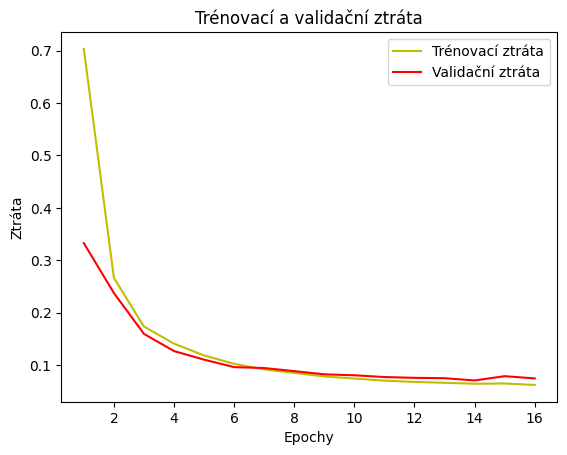

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(1, len(loss)+1)

plt.plot(epochs, loss, 'y', label='Trénovací ztráta')
plt.plot(epochs, val_loss, 'r', label='Validační ztráta ')
plt.title('Trénovací a validační ztráta')
plt.xlabel('Epochy')
plt.ylabel('Ztráta')
plt.legend()
#plt.show()
plt.savefig('./training_loss.png')

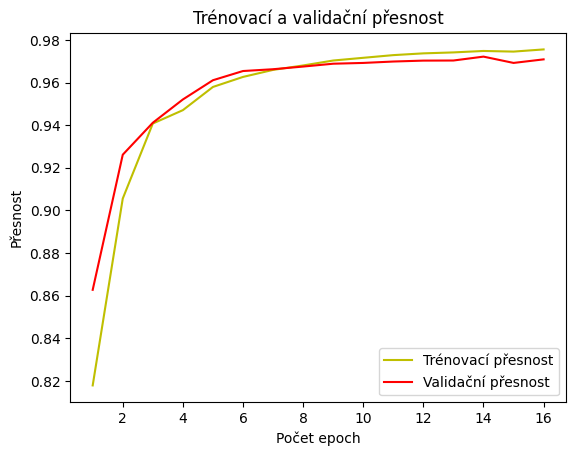

In [27]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs=range(1, len(loss)+1)

plt.plot(epochs, loss, 'y', label='Trénovací přesnost')
plt.plot(epochs, val_loss, 'r', label='Validační přesnost')
plt.title('Trénovací a validační přesnost')
plt.xlabel('Počet epoch')
plt.ylabel('Přesnost')


plt.legend()
#plt.show()
plt.savefig('./validation_loss.png')

1/1 [==============================] - 1s 544ms/step


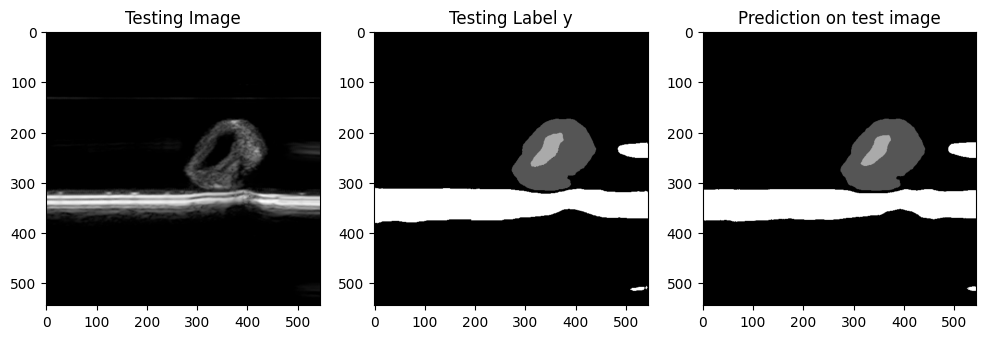

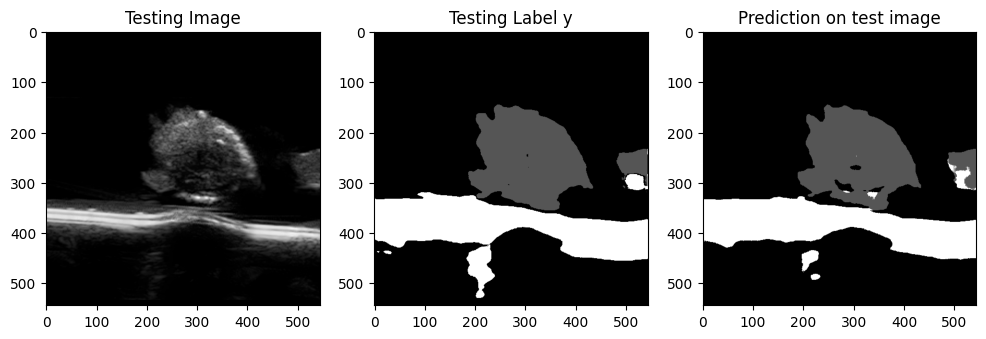

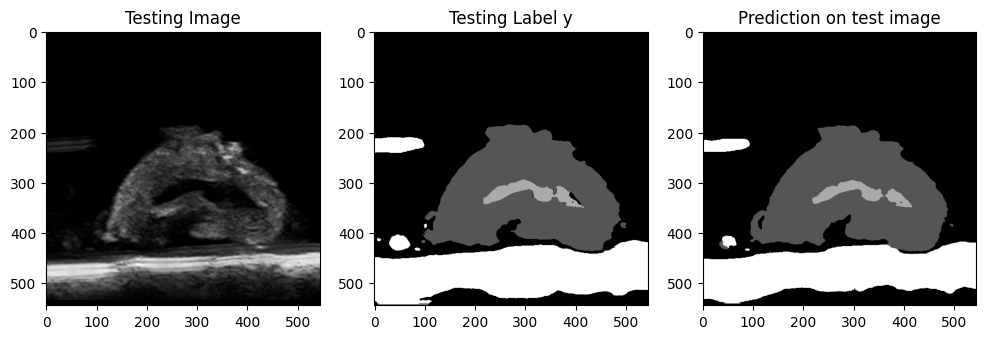

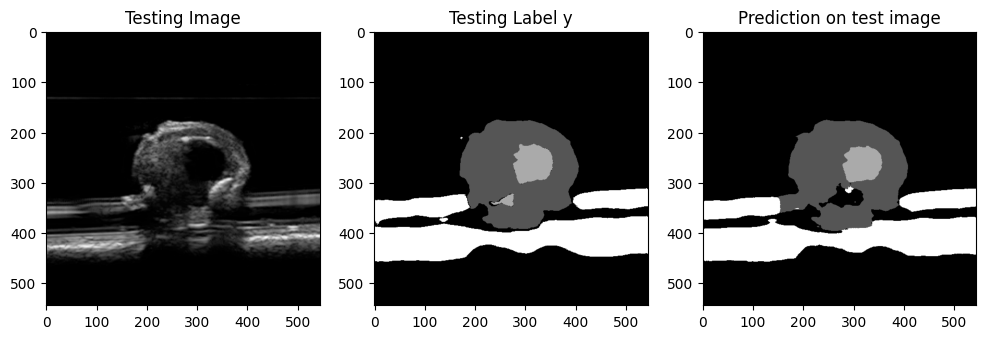

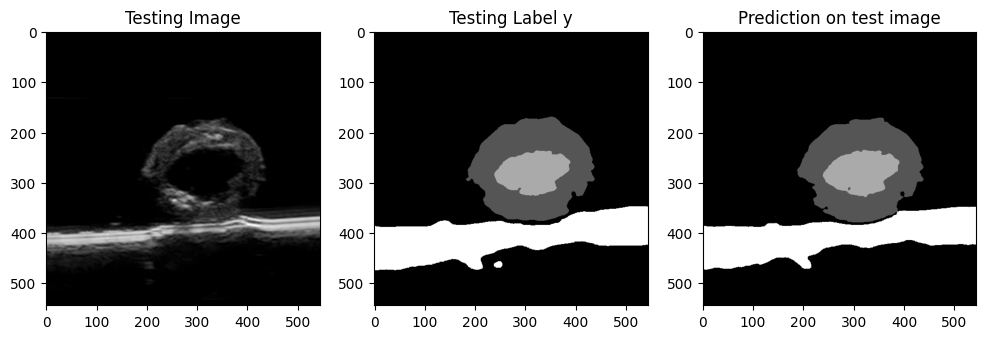

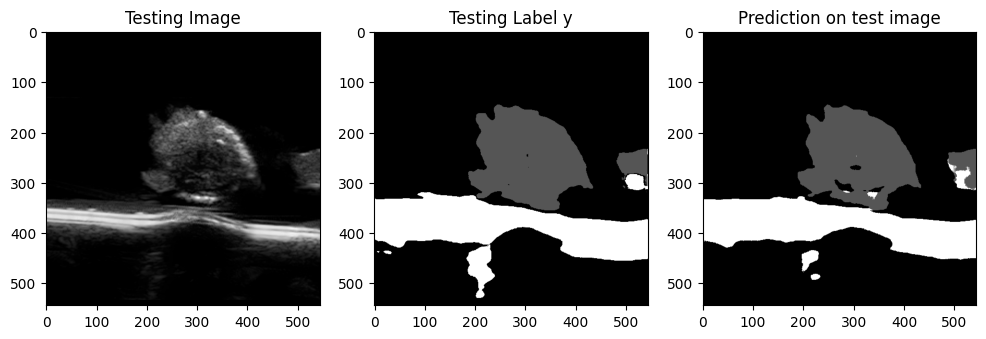

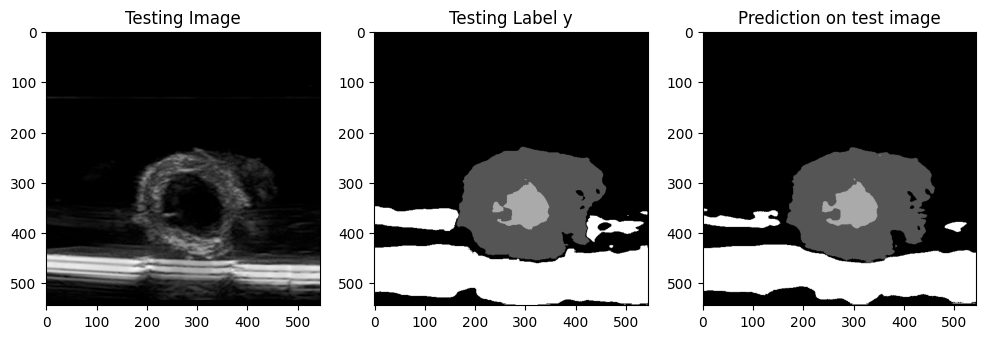

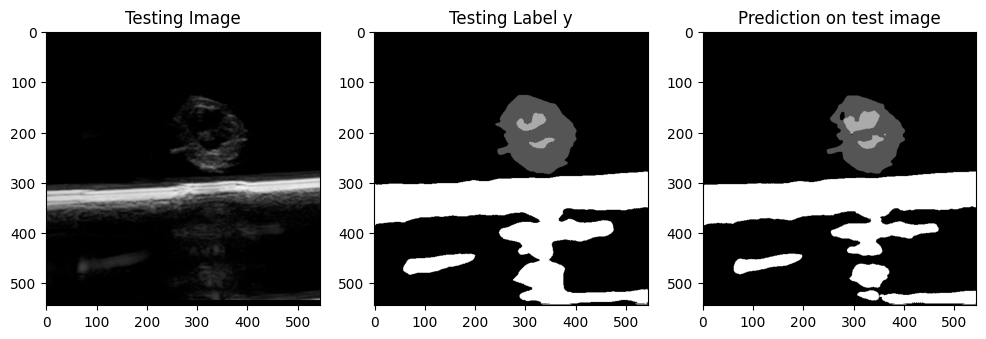

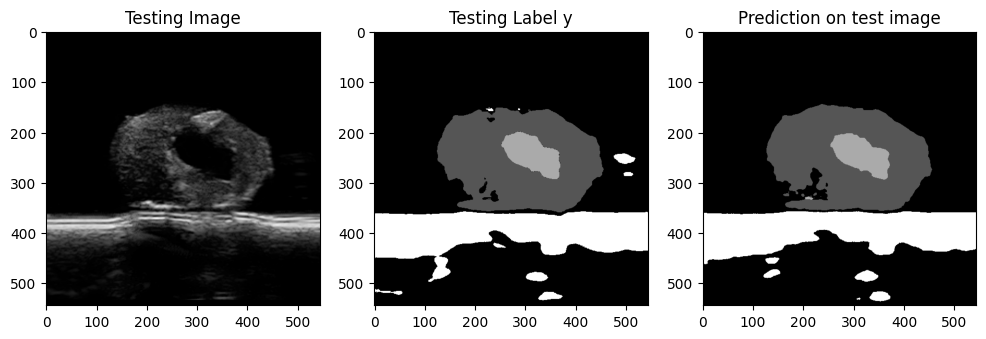

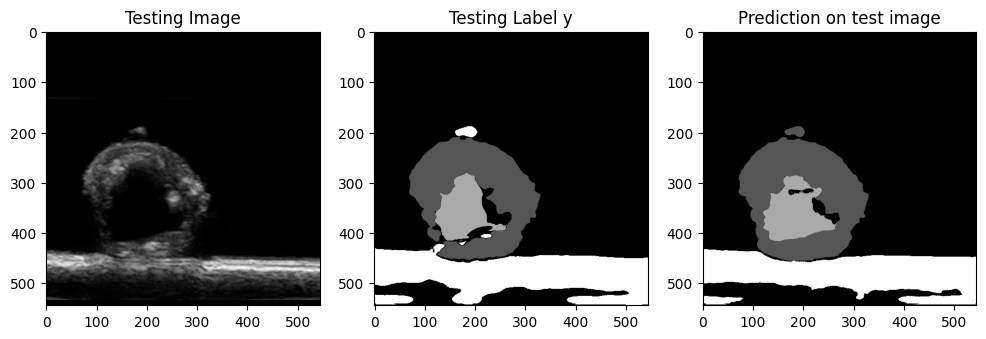

In [32]:
for i in range(0,10):
    import random
    test_img_number = random.randint(0, len(X_test))
    test_img = X_test[test_img_number]
    ground_truth=y_test[test_img_number]
    test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img_norm, 0)
    prediction=(model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]

    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label y')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, cmap='gray')
    save_name = './pred_fig_'+str(i)+'.png'
    #plt.show()
    plt.savefig(save_name)

Příklad predikcí na testovacím datasetu

In [33]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

3/3 [==============================] - 41s 13s/step
Mean IoU = 0.8908096


IoU => Intersection over Union

IoU = true positive / (true positive + false positive + false negative)